# Setup

#### Load Packages

In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

# add parent directory to path
import sys
sys.path.append('..')

# import packages
import numpy as np
import matplotlib.pyplot as plt
import time

# import modules
import LimitedCommitmentModel as lmc
from figures import *
# from checks import *

#### Compile C++ files

In [2]:
# compile c++ files
model = lmc.HouseholdModelClass(par={'num_Ctot':100})
try:
    model.link_to_cpp(force_compile=True)
except:
    model.cpp.delink()
    model.link_to_cpp(force_compile=True)

## User Settings

#### Specify Models

In [3]:
# Default settings
do_simulate = True
do_load     = False
do_save     = False


baseline_settings = {
    # Number of periods
    'T': 10,
    
    # Technical settings
    'threads': 50,
    'do_egm': True,
    # 'num_love': 41,
    # 'num_power': 41,
    # 'num_A': 150,
    # 'centered_gradient': True,
    # 'interp_inverse': True,
    
    # Numerical settings
    
    # Parameters
    'sigma_love': 0.1,
    'p_meet': 0.1,
    
    # Simulation
    'init_A': 1.0,
    'init_love': 0.0,
    'init_power_idx': 1,
    
}

# Model settings
specs = {
        
    'Model 1':    
        {'latexname': '$\kappa_w = 0.50, \sigma_{\psi} = 0.1$', 
         'load': do_load,
         'save': do_save,
         'par':{**baseline_settings,
                }
        },
        
    'Model 2':    
        {'latexname':'$\kappa_w = 0.23, \sigma_{\psi} = 0.1$', 
         'load': do_load,
         'save': do_save,
         'par':{**baseline_settings,
                'div_A_share': 0.23,
                }
        },
        
    'Model 3':    
        {'latexname': '$\kappa_w = 0.50, \sigma_{\psi} = 0.0$', 
         'load': do_load,
         'save': do_save,
         'par':{**baseline_settings,
                'sigma_love': 0.0,
                }
        },
}

## Run models

#### Overview

#### Solve/Load models

In [4]:
# solve different models
models = {}
for name,spec in specs.items():
        #unpack
        par = spec['par']
        do_load = spec['load']
        do_save = spec['save']
        
        if do_load:
            print(f'loading {name}...')
        else:
            print(f'running {name}...')
        
        # setup model
        models[name] = lmc.HouseholdModelClass(name=name, par=spec['par'], load=do_load)
        models[name].spec = spec
        
        # link to cpp
        try:
            models[name].link_to_cpp(force_compile=False)
        except:
            models[name].cpp.delink()
            models[name].link_to_cpp(force_compile=False)
        
        # solve and simulate
        if not do_load:
            # solve
            time0 = time.time()
            models[name].solve()
            solution_time = time.time()-time0
            models[name].sol.solution_time[0] = solution_time
            
            #simulate
            if do_simulate:
                models[name].simulate()
        
        # save model
        if do_save:
            models[name].save()
        
# Save model names
model_names  = list(models.keys())

running Model 1...
running Model 2...
running Model 3...


#### Speed

In [5]:
for name in model_names:
    solution_time = models[name].sol.solution_time
    minutes, seconds = divmod(solution_time, 60)
    seconds, ms      = divmod(seconds*100, 100)
    print(f"{name:16}: {int(minutes):2} minutes, {int(seconds):2} seconds, {int(ms):2} ms")


Model 1         :  0 minutes,  0 seconds, 36 ms
Model 2         :  0 minutes,  0 seconds, 32 ms
Model 3         :  0 minutes,  0 seconds, 16 ms


Groups of variables

In [6]:
def getVariablesWith(*args: str, no: list = None, model = model):
    return [var for var in list(model.sol.__dict__.keys()) if all(words in var for words in args) and (no is None or all(words not in var for words in no))]

Cw_priv = getVariablesWith('Cw_priv_')
Cm_priv = getVariablesWith('Cm_priv_')
Cw_single = getVariablesWith('Cw', 'to_single', no=['tot'])
Cm_single = getVariablesWith('Cw', 'to_single', no=['tot'])
C_couple = getVariablesWith('C', 'to_couple', no=['tot'])
EmargV = getVariablesWith('EmargV')
Vw = getVariablesWith('Vw', no=['marg','vec'])
Vm = getVariablesWith('Vm', no=['marg','vec'])

# Figures

In [7]:
# Choose index
t  = 9
iP = 10
iL = 20
iA = 22
idx = (t,iP,iL,iA)

# group of indexes
idx_low = (t,iP-8,iL,iA)
idx_high = (t,iP+8,iL,iA)

indexes = {   '$\mu_{T-1}='+f'{models[model_names[0]].par.grid_power[idx_low[1]]:2.2f}$':idx_low,
              '$\mu_{T-1}=0.50$': idx, 
              '$\mu_{T-1}='+f'{models[model_names[0]].par.grid_power[idx_high[1]]:2.2f}$': idx_high}


print(f"Time  : {t} / {models[model_names[0]].par.T-1}")
print(f"Power : {models[model_names[0]].par.grid_power[iP]}")
print(f"Love  : {models[model_names[0]].par.grid_love[iL]}")
print(f"Assets: {models[model_names[0]].par.grid_A[iA]}")

Time  : 9 / 9
Power : 0.5
Love  : 0.0
Assets: 5.082863492175902


In [8]:
# # Choose model
# model = models['Deterministic Love']

# # Choose variables
# variables = {"Bargaining"        : "placeholder",}

# # Plot
# plotter = ModelPlot('variables', model, variables, idx)
# plotter.plot_using(plot_surplus)

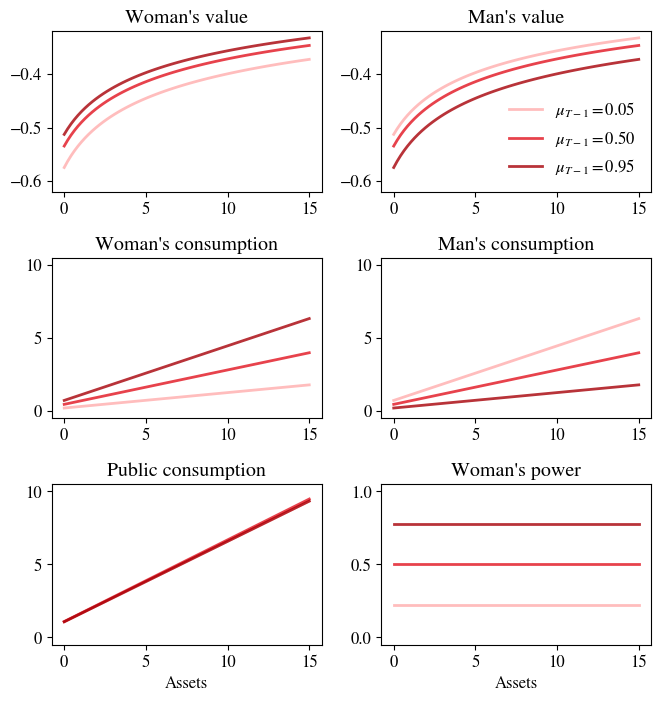

In [9]:
# Choose model

# Choose variables
variables = {r"Woman's value, $V_{w,t}^{m}$"        : "Vw_start_as_couple",
             r"Man's value, $V_{m,t}^{m}$"          : "Vm_start_as_couple", 
             r"Woman's consumption, $c_{w,t}$"  : "Cw_priv_start_as_couple", 
             r"Man's consumption, $c_{m,t}$"    : "Cm_priv_start_as_couple", 
             r"Public consumption, $c_{t}$"   : "C_pub_start_as_couple", 
             r"Woman's power, $\mu_t^{\star}$"        : "power"}
variables = {r"Woman's value"        : "Vw_start_as_couple",
             r"Man's value"          : "Vm_start_as_couple", 
             r"Woman's consumption"  : "Cw_priv_start_as_couple", 
             r"Man's consumption"    : "Cm_priv_start_as_couple", 
             r"Public consumption"   : "C_pub_start_as_couple", 
             r"Woman's power"        : "power"}

plotter = ModelPlot('variables', models, variables, indexes, size='A4')

# Plot
colors = 'black'
colors = [plotter.color_palette['light_red'], plotter.color_palette['red'], plotter.color_palette['dark_red']]
linestyles = [':', '--', '-']
linestyles = '-'
# colors = [plotter.color_palette['blue'], plotter.color_palette['yellow'], plotter.color_palette['red']]
# linestyles = ['-']
x_labels = [''] * 6
x_labels[4:6] = ['Assets']*2

y_grid = [(-0.6 -0.02,-0.34 + 0.02)] * 2 + [(0 -0.5,10 +0.5)] * 3 +[(-0.05,1.05)]

plotter.plot_using(plot_var_over_assets, models = models['Model 1'], colors=colors, save_as='pol_asset_base', linestyles=linestyles, y_grid=y_grid, x_labels=x_labels, subplot_legends=1, subplot_settings={'alpha':0.8})

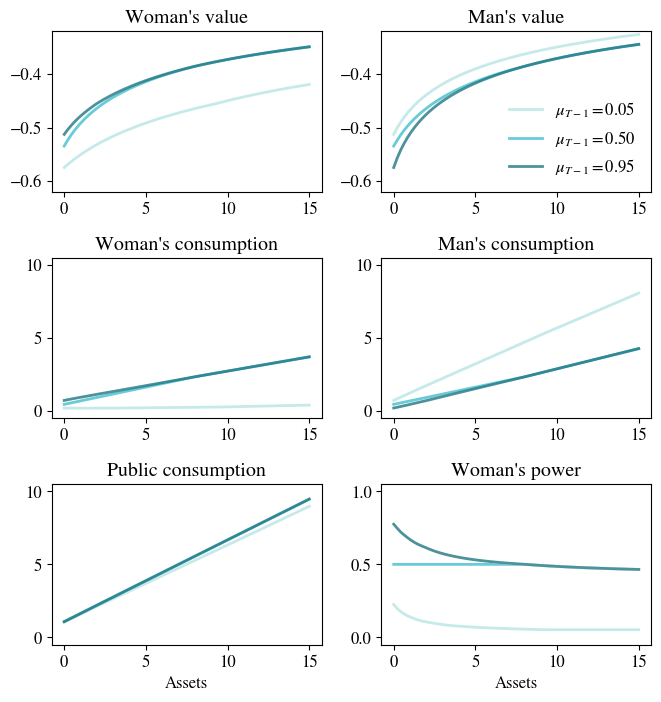

In [10]:
colors = [plotter.color_palette['light_blue'], plotter.color_palette['blue'], plotter.color_palette['dark_blue']]
plotter.plot_using(plot_var_over_assets, models = models['Model 2'], save_as = 'pol_asset_divA', colors=colors, linestyles=linestyles, y_grid = y_grid, x_labels=x_labels, subplot_legends=1, subplot_settings={'alpha':0.8})


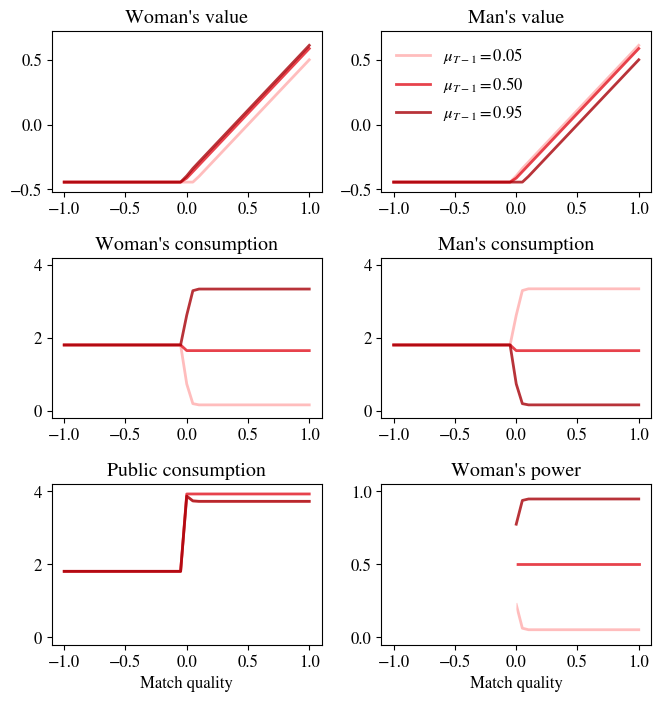

In [11]:
y_grid = [(-0.5 -0.02,0.7 + 0.02)] * 2 + [(0 -0.2,4 +0.2)] * 3 +[(-0.05,1.05)]
x_labels[4:6] = ['Match quality']*2
colors = [plotter.color_palette['light_red'], plotter.color_palette['red'], plotter.color_palette['dark_red']]
plotter.plot_using(plot_var_over_love, models = models['Model 1'], colors=colors, save_as='pol_love_base', linestyles=linestyles, y_grid = y_grid, x_labels=x_labels, subplot_legends=1, subplot_settings={'alpha':0.8})

## Simulation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['#E1131F', '#43BECE', '#FFC215']


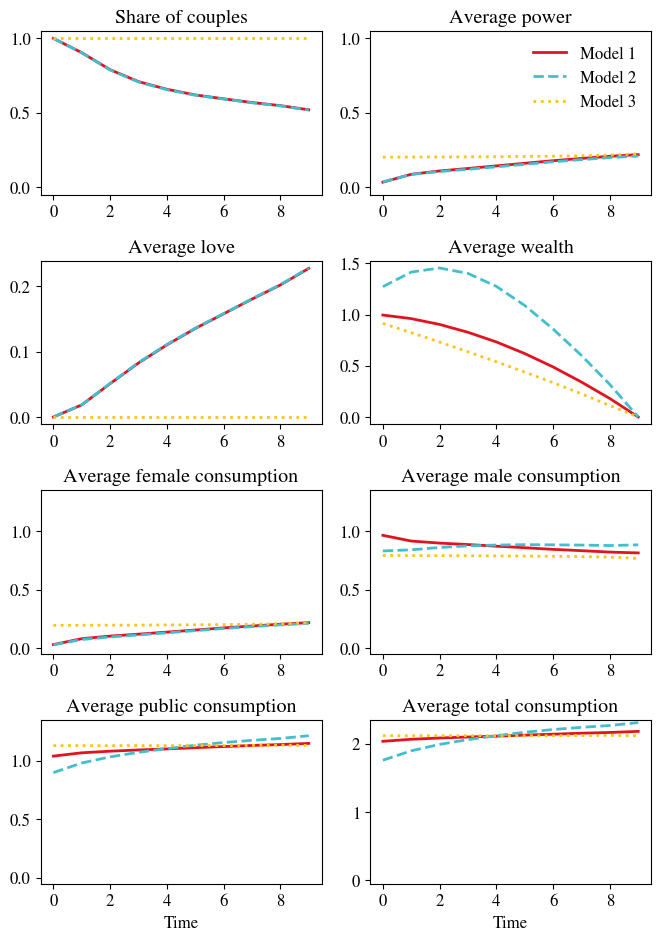

In [12]:
# Choose variables
variables = {"Share of couples" : 'couple',
             "Average power" : 'power',
             "Average love" : 'love',
             "Average wealth" : 'A',
             "Average female consumption" : 'Cw_priv',
             "Average male consumption" : 'Cm_priv',
             "Average public consumption" : 'Cw_pub',
             "Average total consumption" : 'C_tot'}

y_grid = [None]*8
y_grid[0:1] = [(-0.05,1.05)]*2

# Set y grid for consumption variables
# Option one: shared
y_grid[4:7] = [(0.0 - 0.05, 1.3 + 0.05)]*3 # + [(1.077, 1.102)]
y_grid[7] = (0.0 - 0.05, 2.3 + 0.05)

# Option two: centered
# for i in range(4,8):
#     variable = list(variables.values())[i]
#     center = getattr(models['Model 3'].sim,variable)[0,0] # get level of variable from model 3 in first period for first individual (all individuals are identical)
#     y_grid[i] = (center - 0.36, center + 0.36)

# Option 3: individual
#y_grid[4:8] = [None]*4

# lines
colors = [plotter.color_palette['red'], plotter.color_palette['blue'], plotter.color_palette['yellow']]
linestyles = ['-', '--', ':']

x_labels = [''] * 8
x_labels[6:8] = ['Time']*2

# Plot
funcs = {'mean': lambda x: np.nanmean(x, axis=0),}
plotter = ModelPlot('variables', models, variables, funcs, size='A4')
fig = plotter.plot_using(plot_simulated, subplot_legends=1, y_grid=y_grid, subplot_settings = {'subsample':'couple'}, colors = colors, linestyles = linestyles, x_labels=x_labels)

# Make first plot with Share of couples
# get axes
ax = fig.get_axes()
# remove all curves in axes[0]
ax[0].clear()

print(colors)
for i, m in enumerate(list(models.values())):
    ax[0] = plot_simulated(m, 'couple', lambda x: np.nanmean(x, axis=0), ax=ax[0], title=list(variables.keys())[0], color=colors[i], linestyle=linestyles[i], y_grid=(-0.05,1.05), x_label=x_labels[0])
# ax[0] = plot_simulated(models['Baseline'], 'couple', lambda x: np.nanmean(x, axis=0), ax=ax[0], title=list(variables.keys())[0])
ax[0].legend().remove()

plotter.save_plot(fig, figname='simulation')
fig